# Finding Heavy Traffic Indicators on I-94

In this project, we're going to analyze a [dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).

The goal of our analysis is to determine a few indicators of heavy traffic on I-94, such as weather type, day of the week, hour, etc.

---
## Dataset

Dataset we are going to work with was created by John Hogue and can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

Below are descriptions of the columns:
- <code>holiday</code> - US National holidays plus regional holiday, Minnesota State Fair
- <code>temp</code> - Average temp in kelvin
- <code>rain_1h</code> - Amount in mm of rain that occurred in the hour
- <code>snow_1h</code> - Amount in mm of snow that occurred in the hour
- <code>clouds_all</code> - Percentage of cloud cover
- <code>weather_main</code> - Short textual description of the current weather
- <code>weather_description</code> - Longer textual description of the current weather
- <code>date_time</code> - Hour of the data collected in local CST time
- <code>traffic_volume</code> - Hourly I-94 ATR 301 reported westbound traffic volume


In [1]:
# import libraries
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# show graphs inline
%matplotlib inline

# read dataset
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Our dataset has __48,204 rows__, __9 columns__ and __no null values__. Each row describes traffic and weather data for a specific hour — we have data from 2012-10-02 09:00:00 until 2018-09-30 23:00:00.

Since [the documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data and also, the station only records westbound traffic (cars moving from east to west), we should avoid generalizing our results for the entire I-94 highway.

---
## Analysing traffic volume

We will start the analysis by examining the distribution of traffic volume. 

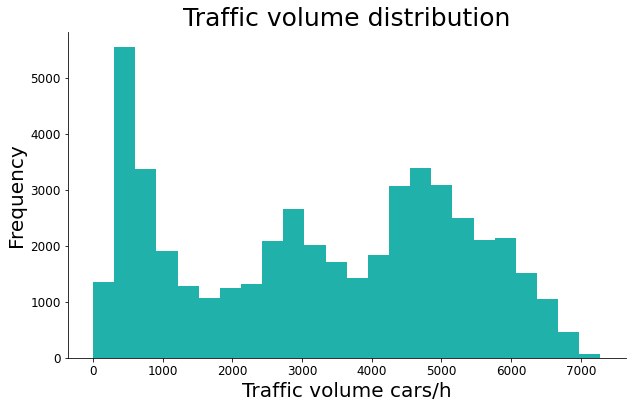

In [4]:
plt.figure(figsize=(10,6))

def create_histogram(data, bins, color, title, title_size, axis_size, tick_size):
    plt.hist(data['traffic_volume'], bins=bins, color=color)
    plt.title(title, fontsize=title_size)
    plt.xlabel('Traffic volume cars/h', fontsize=axis_size)
    plt.ylabel('Frequency', fontsize=axis_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    sns.despine()

# overall distribution of traffic volume
print('\n')
create_histogram(data=traffic, bins=24, color='lightseagreen',
                 title='Traffic volume distribution', title_size=25,
                 axis_size=20, tick_size=12)

In [5]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Observations:
- Number of cars per hour varies from 0 to 7,280, with an average 3,260 cars/h
- The most frequent values of traffic volume range from 300 to 1,000, from 2,500 to 3,500, and from 4,500 to 6,300
- 25% of the time 1,193 or less cars were passing the station
- 25% of the time 4,933 or more cars were passing the station

### Traffic volume: day vs night

Let's take a look on the distribution during day/night hours. We will start by dividing the dataset into 2 parts:
- Daytime data: from 7.00-19.00.
- Nighttime data: from 19.00-7.00.

In [6]:
# convert to datetime object to be able to work with hours
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

# split dataset depending on hours
day = traffic.copy()[(traffic['date_time'].dt.hour>=7)&(traffic['date_time'].dt.hour<19)]
night = traffic.copy()[(traffic['date_time'].dt.hour<7)|(traffic['date_time'].dt.hour>=19)]
print(day.shape)
print(night.shape)

(23877, 9)
(24327, 9)


Now, we can compare traffic volume at night and during the day.

DAYTIME STATS:
count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

NIGHTS STATS:
count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64



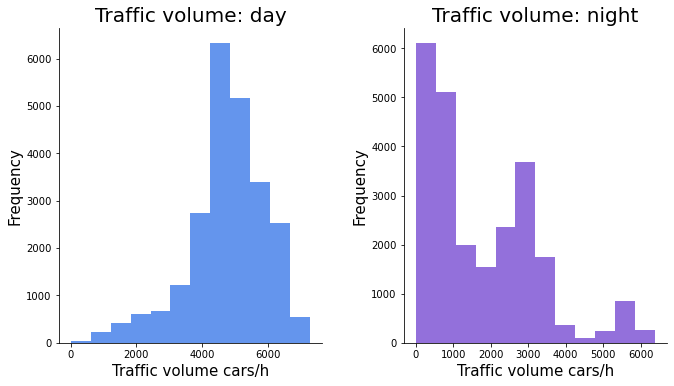

In [7]:
day_stats = day['traffic_volume'].describe()
night_stats = night['traffic_volume'].describe()

# print summary statistics
print(f'\033[1mDAYTIME STATS:\033[0m'
      f'\n{day_stats}'
      f'\n\n\033[1mNIGHTS STATS:\033[0m'
      f'\n{night_stats}'
      f'\n')

# plot distributions of traffic volume during day and night
dfs = [day, night]
titles = ['Traffic volume: day', 'Traffic volume: night']
colors = ['cornflowerblue', 'mediumpurple']

plt.figure(figsize=(10,6))
for i in range(1,3):
    plt.subplot(1, 2, i)
    create_histogram(data=dfs[i-1], bins=12, color=colors[i-1],
                     title=titles[i-1], title_size=20, 
                     axis_size=15, tick_size=10)
    
plt.tight_layout(pad=3)

__Observations night time:__
- Distribution of traffic volume is right-skewed, meaning most of the traffic volume values are low
- Majority of traffic volume values are between 0 and 1,000 cars/h, secondarily, between 2,500 and 3,500 cars/h, with an average of 1,785 cars per hour
- 25% of the time the traffic volume is 530 or less cars/h
- 25% of the time the traffic volume is 2,819 or more cars/h

__Observations day time:__
- Histogram of traffic volume is left-skewed, meaning that most of the traffic volume values are high
- Majority of traffic volume values are between 4,000 and 6,000 cars/h, with an average of 4,762 cars per hour
- 25% of the time the traffic volume is 4,252 or less cars/h
- 25% of the time the traffic volume is 5,559 or more cars/h

We can see that traffic during day is much more busy. Since the goal of the project is to determine indicators of heavy traffic, we will analyse further the __day time subset__.

---
## Time indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

Let's have a look at the traffic volume in different time units: year, month, day of the week or hour.

In [8]:
# function for plotting line graphs
def create_line_plot(data, title, xlabel, title_size, axis_size):
    print('\n')
    plt.plot(data['traffic_volume'], color='indigo')
    plt.title(title, fontsize=title_size)
    plt.xlabel(xlabel, fontsize=axis_size)
    plt.ylabel('Avetage traffic - cars/h', fontsize=axis_size)
    plt.tick_params(axis='both', labelsize=12)
    sns.despine()

### Traffic volume by year

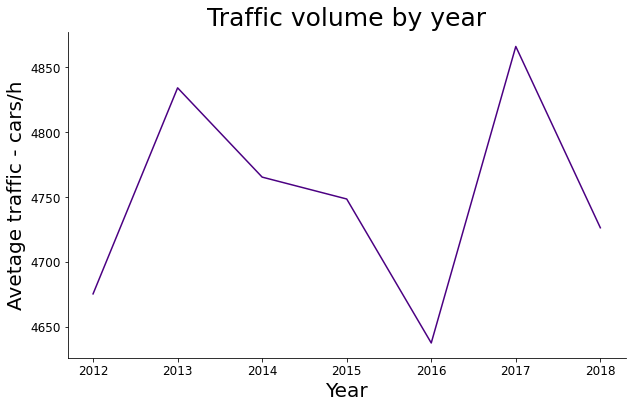

In [9]:
day['year'] = day['date_time'].dt.year
volume_by_year = day.groupby('year').mean()

plt.figure(figsize=(10,6))
create_line_plot(data=volume_by_year,
                 title='Traffic volume by year', title_size=25,
                 xlabel='Year', axis_size=20)

The lowest traffic was recorded in 2016, followed by peak in 2017. One possible explanation would be that in 2016, there was some kind of reconstruction on the road.

### Traffic volume by month

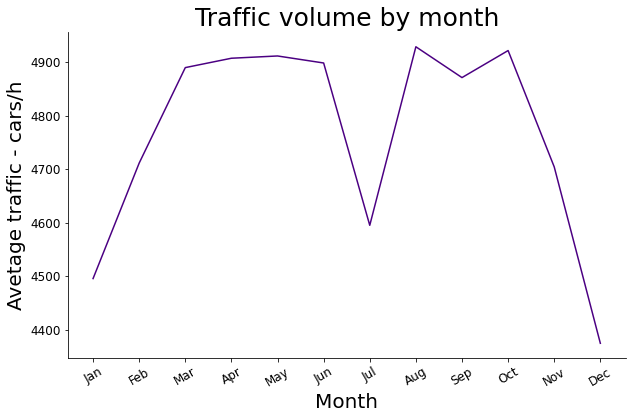

In [10]:
day['month'] = day['date_time'].dt.month
volume_by_month = day.groupby(['month']).mean()

plt.figure(figsize=(10,6))
create_line_plot(data=volume_by_month,
                 title='Traffic volume by month', title_size=25,
                 xlabel='Month', axis_size=20)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=30)
plt.show()

Traffic is less heavy in cold months (November-February), while the rest of the year is quite busy (March-October), with one exception - July. Let's have a closer look at this in the next step.

### Traffic volume in July by year

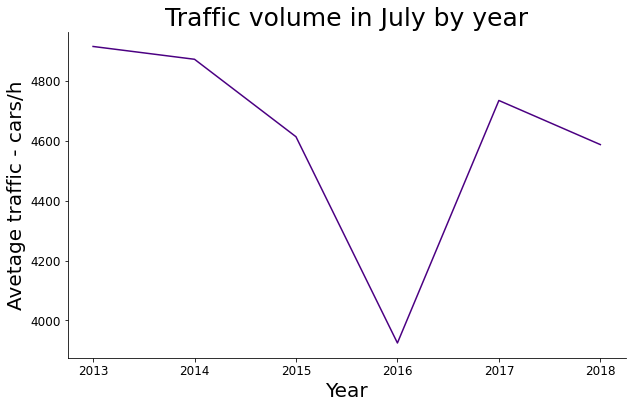

In [11]:
# select only July in each year
month_july = day[day['month'] == 7]
volume_by_year_july = month_july.groupby(['year']).mean()

plt.figure(figsize=(10,6))
create_line_plot(data=volume_by_year_july,
                 title='Traffic volume in July by year', title_size=25,
                 xlabel='Year', axis_size=20)

All years show quite heavy traffic volume during month July, except for year 2016, which we pointed out already in the analysis of the traffic volume by year. Overall decrease of traffic in this month is caused by the construction in 2016. [An article](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696) from 2016 supports this hypothesis.

### Traffic volume by day of the week

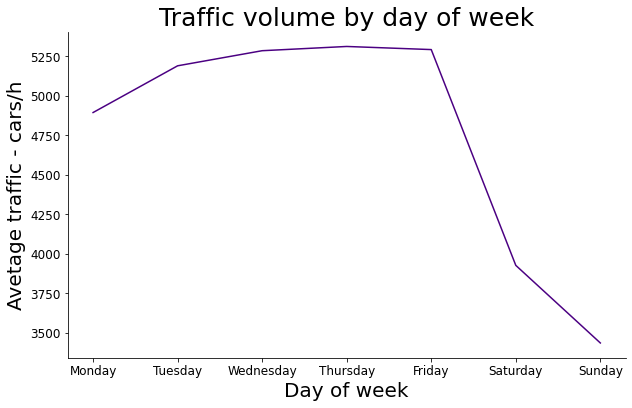

In [12]:
day['day_of_week'] = day['date_time'].dt.dayofweek
volume_by_dayofweek = day.groupby(['day_of_week']).mean()

plt.figure(figsize=(10,6))
create_line_plot(data=volume_by_dayofweek,
                 title='Traffic volume by day of week', title_size=25,
                 xlabel='Day of week', axis_size=20)
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

Traffic volume is significantly heavier on business days (Monday – Friday). Except for Monday, we only see values over 5,000 during business days. Traffic is lighter on weekends, with values below 4,000 cars.

### Traffic volume by hour

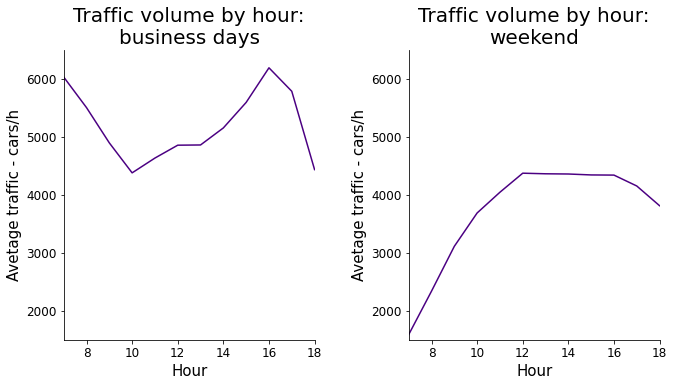

In [13]:
# split the data to business days and weekend
day['hour'] = day['date_time'].dt.hour
business_days = day.copy()[day['day_of_week']<=4] # till Friday
weekend = day.copy()[day['day_of_week']>=5]
volume_business_days = business_days.groupby('hour').mean()
volume_weeked = weekend.groupby('hour').mean()

dfs = [volume_business_days, volume_weeked]
titles = ['Traffic volume by hour:\nbusiness days', 'Traffic volume by hour:\nweekend']

plt.figure(figsize=(10,6))
for i in range(1,3):
    plt.subplot(1,2,i)
    create_line_plot(data=dfs[i-1],
                     title=titles[i-1], title_size=20,
                     xlabel='Hour', axis_size=15)
    plt.xlim(7,18)
    plt.ylim(1500,6500)
    plt.tight_layout(pad=3)

The traffic is heavier on business days for almost all daytime hours with respect to weekends. Rush hours when people commute to and from work are visible on the plot with peaks between 7:00 - 8:00 and between 16:00 - 17:00. During weekend there are no clear peaks, the traffic volume gradually increases from 7:00 till 12:00, decreasing starts after 16:00.

--- 
## Weather indicators

Another possible indicator of heavy traffic is weather. We can find information about the weather in the following columns: <code>temp</code>, <code>rain_1h</code>, <code>snow_1h</code>, <code>clouds_all</code>, <code>weather_main</code>, <code>weather_description</code>. The first 4 of them are numerical, so let's try to figure out how they correlate with <code>traffic_volume</code>.

In [14]:
day.corr()['traffic_volume'][['temp', 'rain_1h', 'snow_1h', 'clouds_all']]

temp          0.128317
rain_1h       0.003697
snow_1h       0.001265
clouds_all   -0.032932
Name: traffic_volume, dtype: float64

<code>rain_1h</code>, <code>snow_1h</code>, <code>clouds_all</code> show low correlation. We will closer look at the correlation between temperature and traffic volume.

### Temperature

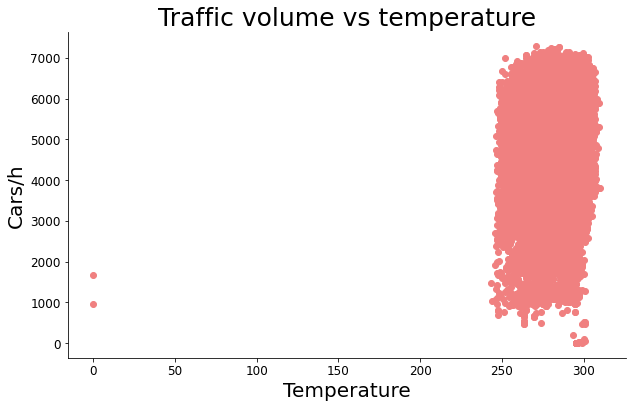

In [15]:
# create scatter plot showing correlation between temperature and traffic volume
print('\n')
plt.figure(figsize=(10,6))
plt.scatter(day['temp'], day['traffic_volume'], color='lightcoral')
plt.title('Traffic volume vs temperature', fontsize=25)
plt.xlabel('Temperature', fontsize=20)
plt.ylabel('Cars/h', fontsize=20)
plt.tick_params(axis='both', labelsize=12)
sns.despine()

We can conclude that actually there is no valid correlation between temperature and traffic volume, meaning that temperature isn't a reliable indicator for heavy traffic.

### Weather types

We will first look at each weather type (<code>weather_main</code>) and compare the average traffic volumes.

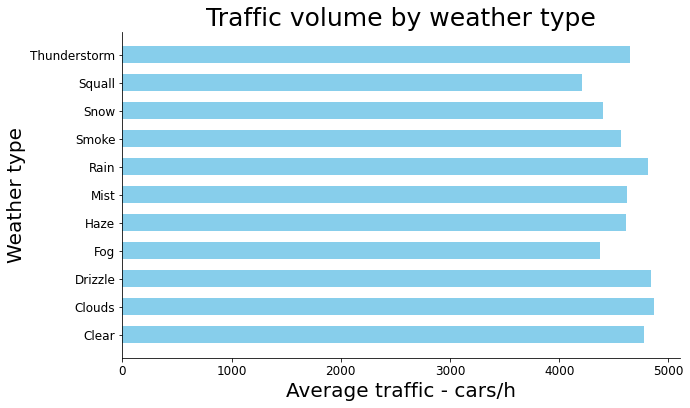

In [16]:
volume_by_weather = day.groupby('weather_main').mean()

print('\n')
plt.figure(figsize=(10,6))
plt.barh(volume_by_weather.index, volume_by_weather['traffic_volume'],
         color='skyblue', height=0.6)
plt.title('Traffic volume by weather type', fontsize=25)
plt.xlabel('Average traffic - cars/h', fontsize=20)
plt.ylabel('Weather type', fontsize=20)
plt.tick_params(axis='both', labelsize=12)
sns.despine()

There are no weather types where traffic volume exceeds 5,000 cars/h, so we cannot identify any heavy traffic indicator from the weather_main column. Let's plot the results for the <code>weather_description</code> column instead.

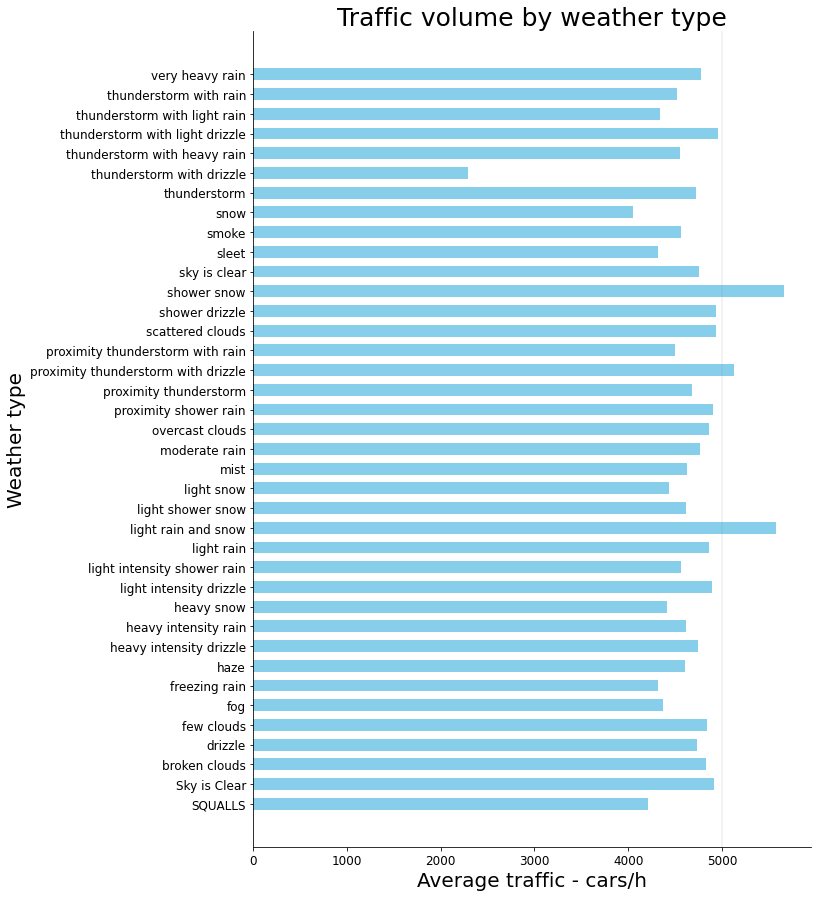

In [17]:
volume_by_weather_description = day.groupby('weather_description').mean()

print('\n')
plt.figure(figsize=(10,15))
plt.barh(volume_by_weather_description.index, volume_by_weather_description['traffic_volume'],
         color='skyblue', height=0.6)
plt.title('Traffic volume by weather type', fontsize=25)
plt.xlabel('Average traffic - cars/h', fontsize=20)
plt.ylabel('Weather type', fontsize=20)
plt.tick_params(axis='both', labelsize=12)
plt.axvline(x=5000, color='grey', linewidth=0.2)
sns.despine()

We can identify the 3 weather types that led to heavy traffic of more than 5,000 cars/h: __shower snow, light rain and snow, proximity thunderstorm with drizzle__.

Result is surprising. There are other weather types in the dataset that represent worse wather and hypothesis would be that traffic volume will be highest in these weather conditions, such as thunderstorm. One possible explanation here is that really bad weather conditions are usually forecast in advance, so people try to do their best not to travel by car on such days.

---
## Conclusion

Goal of the project was to find indicators that influence the traffic volume on the I-94 Interstate highway.

__Time indicators__:
- Traffic is usually heavier during warm months (March–October) compared to cold months (November–February)
- Traffic is usually heavier on business days compared to the weekends
- On business days, the rush hours are around 7:00 and 16:00

__Weather indicators__:
- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

It's important to note that during the analysis we focused on the subset of data recorded during day hours bewteen 7.00 and 19.00.